# Delaunay Tesselation Field Estimator in 2D

In [31]:
#Load the numpy and scipy libraries
import numpy as np
from scipy.spatial import Delaunay
import numba
from numba import float32, float64, int64
from typing import Union


@numba.jit(nopython=True, nogil=True)
def triangle_area(sim: int64[:], points: float64[:,:]):
    return abs(np.linalg.det(np.stack((points[sim[1]] - points[sim[0]], 
                                       points[sim[2]] - points[sim[0]])))) / 2


@numba.jit(nopython=True, nogil=True)
def compute_densities(pts: float64[:,:], simps: float64[:,:],
                      m: Union[float64, float64[:]]) -> np.ndarray:
    M = len(pts)
    rho = np.zeros(M, dtype='float64')
    for sim in simps:
        vol = triangle_area(sim, pts)
        for index in sim:
            rho[index] += vol
    return (2 + 1) * m / rho
   

@numba.jit(nopython=True, nogil=True)
def compute_gradients(pts: float64[:,:], simps: float64[:,:], rho: float64[:],
                      v: float64[:,:]) -> tuple[np.ndarray, np.ndarray]:
    N = len(simps)
    Drho = np.zeros((N, 2), dtype='float64')
    Dv   = np.zeros((N, 2, 2), dtype='float64')

    for i, s in enumerate(simps):
        [p0, p1, p2] = pts[s]
        [r0, r1, r2] = rho[s]
        [v0, v1, v2] = v[s]

        A: float64[:,:] = np.stack((p1 - p0, p2 - p0))
        det = A[0,0] * A[1,1] - A[1,0] * A[0,1]
        Ainv = np.array([[A[1,1] / det, -A[0,1] / det],
                         [-A[1,0] / det, A[0,0] / det]])
        # Ainv: float64[:,:] = np.linalg.inv(A)
        # Drho[i] = np.linalg.solve(A, np.array([r1 - r0, r2 - r0]))
        Drho[i] = Ainv @ np.array([r1 - r0, r2 - r0])
        Dv[i] = Ainv @ np.stack((v1 - v0, v2 - v0))
        # Dv[i] = np.linalg.solve(A, np.stack((v1 - v0, v2 - v0)))
    
    return (Drho, Dv)


@numba.jit(nopython=True, nogil=True)
def map_affine(a, b, c):
    assert(len(a) == len(b) == len(c))
    result = np.zeros_like(a)
    for i in range(len(a)):
        result[i] = a[i] + b[i] @ c[i]
    return result


#The Delaunay Tesselation Field Estimator 
class DTFE:
    def __init__(self, points, velocities, m):
        print("Delaunay Tesselation Field Estimator initialization:")
        self.velocities = velocities
        print("\t-Evaluate Delaunay tessellation")
        self.delaunay = Delaunay(points)
        
        #Area of a triangle
        
        #The density estimate
        print("\t-Evaluate density estimate")
        self.rho = compute_densities(self.delaunay.points, self.delaunay.simplices, m)
        #The gradients
        print("\t-Evaluate gradients")
        self.Drho, self.Dv = compute_gradients(self.delaunay.points, self.delaunay.simplices,
                                               self.rho, self.velocities)

    #The interpolations
    def density(self, x, y):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.rho[pointIndex], self.Drho[simplexIndex],
                          np.c_[x,y] - self.delaunay.points[pointIndex])

    def v(self, x, y):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.velocities[pointIndex], self.Dv[simplexIndex],
                          np.c_[x, y] - self.delaunay.points[pointIndex])

    def theta(self, x, y):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y])
        return self.Dv[simplexIndex][...,0,0] + self.Dv[simplexIndex][...,1,1]

    def omega(self, x, y):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y])
        return self.Dv[simplexIndex][...,1,0] - self.Dv[simplexIndex][...,0,1]

Example

In [32]:
L = 256
points = np.load("example/points.npy")
velocities = np.load("example/velocities.npy")
m = np.ones(len(points))

In [33]:
%%time
dtfe = DTFE(points, velocities, m)

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients
CPU times: user 4.73 s, sys: 60.9 ms, total: 4.79 s
Wall time: 4.9 s


In [35]:
n = int(5 * L)
X, Y = np.meshgrid(np.arange(0, L, L / n), np.arange(0, L, L / n))

dens = dtfe.density(X.flat, Y.flat).reshape((n, n))
vel  = dtfe.v(X.flat, Y.flat).reshape((n,n,2))
div  = dtfe.theta(X.flat, Y.flat).reshape((n, n))
curl = dtfe.omega(X.flat, Y.flat).reshape((n,n))

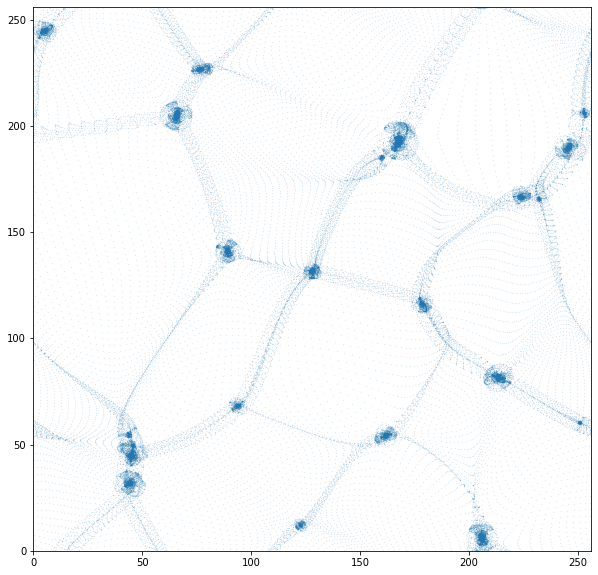

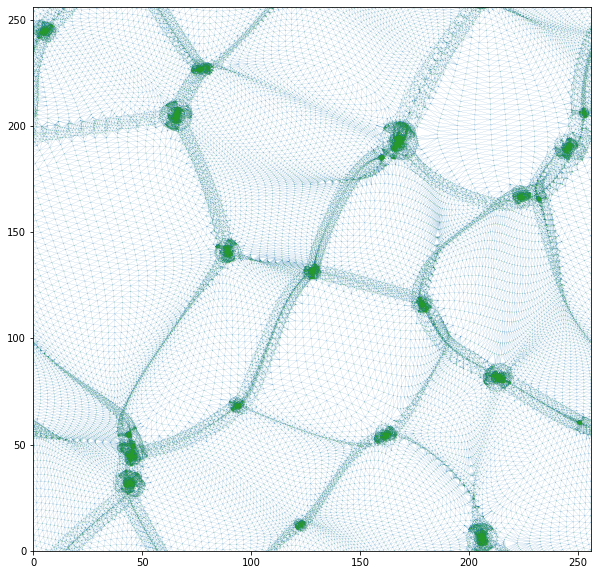

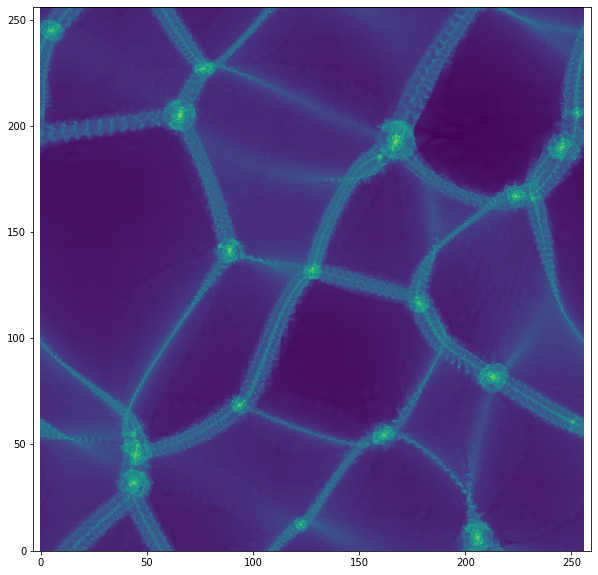

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
plt.plot(points[:,0], points[:,1], '.', markersize=0.1)
plt.xlim([0, L])
plt.ylim([0, L])
plt.savefig('example/points.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

plt.figure(figsize = (10, 10))
plt.triplot(points[:,0], points[:,1], dtfe.delaunay.simplices, linewidth=0.1)
plt.plot(points[:,0], points[:,1], '.', markersize=0.1)
plt.xlim([0, L])
plt.ylim([0, L])
plt.savefig('example/delaunay.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

plt.figure(figsize = (10, 10))
plt.pcolormesh(X, Y, np.log(dens), shading='auto')
plt.axis("equal")
plt.savefig('example/density.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

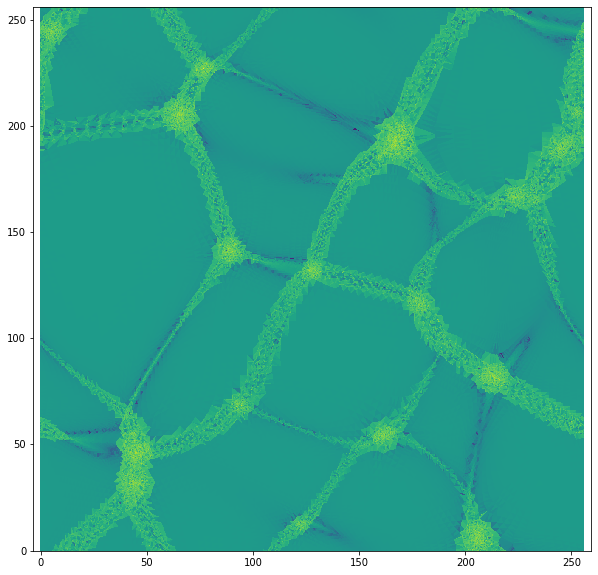

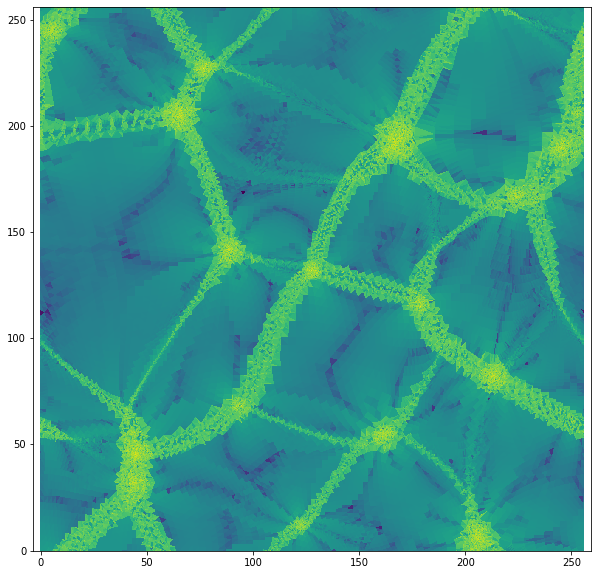

In [37]:
plt.figure(figsize = (10, 10))
plt.pcolormesh(X, Y, np.log(abs(div)), shading='auto')
plt.axis("equal")
plt.show()

plt.figure(figsize = (10, 10))
plt.pcolormesh(X, Y, np.log(abs(curl)), shading='auto')
plt.axis("equal")
plt.show()